# Semantic Segmentation with _Residual U-Net_ architecture - IIIT Pet dataset + PyTorch

- _Image Segmentation is the task of classifying an image at the pixel level_. Every digital picture consists of pixel values, and semantic segmentation involves labelling each pixel.

- _U-net_ is the architecture that maps the image to pixel-level classification.

- Residual blocks for ResNet-18 CNN is used instead of the typical double conv block.

- The Input image dimension is different from the output segmentation map (spatially). This is because the author used _unpadded convolution_, and so the output is reduced by a constant border width. It was assumed that the segmentation object lies in the center of the image.

- This can be avoided by using a padded convolution with a mirror strategy. __mirror strategy — Instead of using zero-padding, mirror image pixel in the border__.

Unet consists of three parts:

1. _The Contracting Path_ — __it helps in getting the context of objects in the image__. Feature map of contracting side learns _to which class an object belongs to_.

1. _The Expanding Path_ — __it helps in the localization of the objects in the image__. Feature map of this side learns _in which position is the object present_.

1. Skip Connection —  __Skip Connections are used to _retain the spatial information_ lost during downsampling the image__. So that, the feature map from the expanding path can get a better context of the position of the original pixels.


#### Implementation specifics

- Simple Double Convolution Layer: An input is passed through _conv 3x3_ -> ReLU -> drop-out.
- After passing through a simple double conv layer, the output feature map passes through a _max-pool_ of 2x2 kernel-size, which reduces the feature map by half (spatially).
- Up-Convolution Layer: The input volume is passed through _Transpose Convolution_ to upsample the feature map.
    - _Transpose Convolution is used with kernel = 2x2 and with stride = 2_.
    - _The output channel dimension in the Transpose Convolution layer is halved as we will be concatenating the feature map from the contracting path_.
- Image Cropper: While concatenating feature map from contracting path to expanding path - _feature map from contracting path needs to be cropped to match the dimension of feature map from expanding path_.

#### References

- [Code reference](https://towardsdev.com/original-u-net-in-pytorch-ebe7bb705cc7)

- [Code Reference](https://www.kaggle.com/code/yosshi999/oxfordiiit-pet-segmentation)

- [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

- [Semantic Segmentation of Aerial Imagery Using U-Net in Python](https://towardsdatascience.com/semantic-segmentation-of-aerial-imagery-using-u-net-in-python-552705238514)

In [1]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
%env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3, 4

env: CUDA_VISIBLE_DEVICES=0, 1, 2, 3, 4


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2, pickle
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from Residual_UNet import ResNet_Block, ResUNet

/home/majumdar/anaconda3/envs/torch-cuda-new/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/majumdar/anaconda3/envs/torch-cuda-new/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")
    
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use different GPUs (1 and 2) for model, while GPU 3 for data-
# device = torch.device("cuda:0,1" if torch.cuda.is_available() else "cpu")

print(f'Available device is {device}')

torch version: 1.13.1
Number of GPU(s) available = 5
Current GPU: 0
Current GPU name: NVIDIA GeForce GTX 1080 Ti
Available device is cuda


In [4]:
# Read annotations .txt file-
data_annotations = pd.read_csv(
    "../Datasets/annotations/list.txt", delimiter=" ",
    skiprows = 6, header = None,
    names = ["stem", "class_id", "species", "breed"]
)

In [5]:
# Apply processing to each path-
data_annotations["class_name"] = data_annotations.stem.map(lambda x: x.split("_")[0])
data_annotations["image"] = data_annotations.stem.map(lambda x: f"../Datasets/images/{x}.jpg")
data_annotations["trimap"] = data_annotations.stem.map(lambda x: f"../Datasets/annotations/trimaps/{x}.png")

In [6]:
# Sanity check-
data_annotations.head(7)

,stem,class_id,species,breed,class_name,image,trimap
0,Abyssinian_100,1,1,1,Abyssinian,../Datasets/images/Abyssinian_100.jpg,../Datasets/annotations/trimaps/Abyssinian_100...
1,Abyssinian_101,1,1,1,Abyssinian,../Datasets/images/Abyssinian_101.jpg,../Datasets/annotations/trimaps/Abyssinian_101...
2,Abyssinian_102,1,1,1,Abyssinian,../Datasets/images/Abyssinian_102.jpg,../Datasets/annotations/trimaps/Abyssinian_102...
3,Abyssinian_103,1,1,1,Abyssinian,../Datasets/images/Abyssinian_103.jpg,../Datasets/annotations/trimaps/Abyssinian_103...
4,Abyssinian_104,1,1,1,Abyssinian,../Datasets/images/Abyssinian_104.jpg,../Datasets/annotations/trimaps/Abyssinian_104...
5,Abyssinian_105,1,1,1,Abyssinian,../Datasets/images/Abyssinian_105.jpg,../Datasets/annotations/trimaps/Abyssinian_105...
6,Abyssinian_106,1,1,1,Abyssinian,../Datasets/images/Abyssinian_106.jpg,../Datasets/annotations/trimaps/Abyssinian_106...


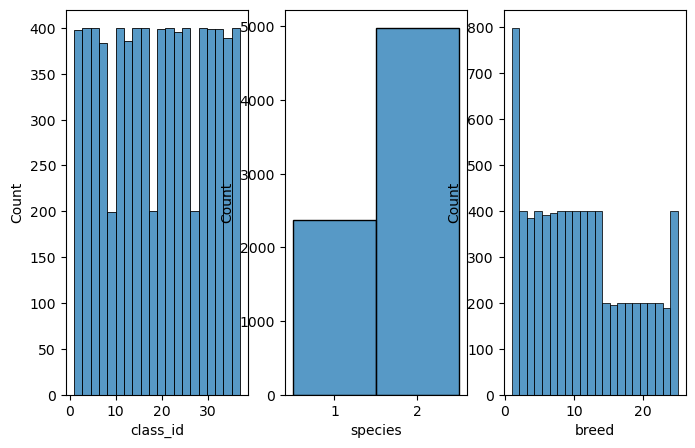

In [7]:
plt.figure(figsize = (8, 5))
plt.subplot(1, 3, 1)
sns.histplot(data_annotations['class_id'])

plt.subplot(1, 3, 2)
sns.histplot(data_annotations.species, discrete = True)

plt.subplot(1, 3, 3)
sns.histplot(data_annotations.breed)

plt.show()

In [ ]:
'''
# Sanity check-
for img, annot in tqdm(zip(data_annotations.image, data_annotations.trimap), total = len(data_annotations)):
    Image.open(img).verify()
    Image.open(annot).verify()
'''

In [8]:
# Define different masks-
MASK_FG = 1
MASK_BG = 2
MASK_IGNORE = 3

In [9]:
# Define transforms for data augmentation-
'''
transform_train = transforms.Compose(
    [
        # transforms.RandomCrop(32, padding = 4),
        transforms.Resize((200, 200)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = (0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225))
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = (0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225)
        ),
    ]
)
'''

train_transforms = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), A.VerticalFlip(p = 0.5),
        A.RandomScale(),
        A.Rotate(border_mode = cv2.BORDER_CONSTANT, mask_value = MASK_BG),
        A.RandomBrightnessContrast(p = 0.2),
        A.SmallestMaxSize(224), A.RandomCrop(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(224), A.CenterCrop(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [10]:
class IIITDataset(torch.utils.data.Dataset):
    '''
    Custom PyTorch Dataset class for IIIT Pet dataset.
    '''
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        img = Image.open(self.data.image.iloc[i]).convert('RGB')
        mask = Image.open(self.data.trimap.iloc[i])
        
        # Resize mask (width, height)-
        mask = mask.resize(size = (200, 200))
        
        # Convert to numpy array from PIL.Image-
        img = np.asarray(img)
        mask = np.asarray(mask)
        '''
        if self.transform:
            img = self.transform(img)
        '''
        if self.transform:
            augmented = self.transform(image = img, mask = mask)
            img, mask = augmented["image"], augmented["mask"]
        
        return img, mask
    

In [11]:
# Use Stratified K-Fold to get train and test indices-
'''
Stratified K-Folds cross-validator.
Provides train/test indices to split data in train/test sets.
This cross-validation object is a variation of KFold that returns
stratified folds. The folds are made by preserving the percentage of
samples for each class.
'''
skf = StratifiedKFold(n_splits = 5)
train_idx, val_idx = next(iter(skf.split(data_annotations, data_annotations.class_id)))

In [12]:
# Sanity check-
len(train_idx), len(val_idx)

(5879, 1470)

In [13]:
print(f"train set = {len(train_idx) / len(data_annotations) * 100:.2f}% &"
      f" test set = {len(val_idx) / len(data_annotations) * 100:.2f}%")

train set = 80.00% & test set = 20.00%


In [14]:
# Get train and test datasets-
train_data = data_annotations.iloc[train_idx]
test_data = data_annotations.iloc[val_idx]

In [15]:
# Sanity check-
train_data.shape, test_data.shape

((5879, 7), (1470, 7))

In [16]:
del train_idx, val_idx, skf

In [17]:
# Create training and test datasets using PyTorch defined class-
train_ds = IIITDataset(data = train_data, transform = train_transforms)
test_ds = IIITDataset(data = test_data, transform = test_transforms)

In [18]:
# Define mean and standard-deviation for data denormalizing data-
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [19]:
def imagenet_denorm(x):
    """
    x: array-like with shape (..., H, W, C)
    """
    
    return (x * std) + mean


In [20]:
del train_data, test_data

In [ ]:
# Sanity check-
# img, mask = train_ds[500]

In [ ]:
# img.shape, mask.shape

In [ ]:
# Sanity check for mask-
# mask[:10, :10]

In [ ]:
# val, cnt = np.unique(ar = mask.numpy(), return_counts = True)
# print(f"number of classes in the mask = {np.unique(ar = mask.numpy())}")

In [ ]:
# Get denormed image by first denorming it and then transposing the axes-
# img = imagenet_denorm(img.numpy().transpose(1, 2, 0))

In [ ]:
# Sanity check-
# img.shape

In [ ]:
'''
# Visualize image and its corresponding mask-
plt.figure(figsize = (8, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.xticks([])
plt.yticks([])

plt.suptitle(f"{data_annotations.loc[200, 'image']} img and segmentation mask")
plt.show()
'''

In [ ]:
# del img, mask

In [ ]:
'''
# Visualize some more images and their corresponding masks/segmentation output maps-
for i in range(5):
    img, mask = train_ds[100 + i]
    img = imagenet_denorm(img.numpy().transpose(1, 2, 0))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    
    plt.xticks([]); plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(mask == MASK_FG)
    plt.xticks([]); plt.yticks([])
    
    plt.show()
'''

In [ ]:
# del img, mask

In [21]:
# Define neural network training hyper-parameters-
num_epochs = 200
batch_size = 64

In [22]:
# There is a bug in IPython where if 'num_workers > 0' 

# Create train and test data loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_ds, batch_size = batch_size,
    shuffle = True, num_workers = 4
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test_ds, batch_size = batch_size,
    shuffle = True, num_workers = 4
    )

In [24]:
'''
# Sanity check-
x, x_mask = next(iter(train_loader))

x.shape, x_mask.shape
# (torch.Size([32, 3, 224, 224]), torch.Size([32, 224, 224]))

# Get number of classes per pixel in mask-
np.unique(ar = x_mask.numpy())
# array([1, 2, 3], dtype=uint8)

x_mask.min(), x_mask.max()

del x, x_mask
'''

### Define _Residual U-Net_ architecture

_same_ convolutions are used instead of _valid_ convolutions.

In [23]:
# Initialize Residual U-Net CNN-
model = ResUNet(
    inp_channels = 3, op_channels = 3,
    features = [64, 128, 256, 512]
    )

In [24]:
def count_trainable_params(model):
    # Count number of trainable parameters in 'model'.
    # Count number of layer-wise parameters and total parameters-
    tot_params = 0
    for param in model.parameters():
        # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
        tot_params += param.nelement()
    
    return tot_params


In [25]:
print(f"Residual U-Net architecture has {count_trainable_params(model)} params")

Residual U-Net architecture has 32436483 params


### Mult-GPU PyTorch Training

__Data Parallelism__

To use data parallelism with PyTorch, you can use the ```DataParallel``` class. When using this class, you define your GPU IDs and initialize your network using a Module object with a ```DataParallel``` object.

```
parallel_net = nn.DataParallel(model, device_ids = [0,1,2])
```

Once defined, you can perform the standard model training steps just as you would with a standard ```nn.Module``` object. For example:

```

# perform a forward pass-
predictions = parallel_net(inputs) 

# computes a loss function-
loss = loss_function(predictions, labels)

# average GPU-losses and perform a backward pass-
loss.mean().backward()

# Update parameters-
optimizer.step()
```

When using this method, you need to ensure that your data is initially stored on one GPU (the “primary GPU”). You should also place your data parallel object on that same GPU. You can do this using code like the following:

```
input        = input.to(0)
parallel_net = parellel_net.to(0)
```
Then, when you call your object it can split your dataset into batches that are distributed across your defined GPUs. Once the operations are complete, the outputs are aggregated on the primary GPU. 

[Reference](https://www.run.ai/guides/multi-gpu/pytorch-multi-gpu-4-techniques-explained)

In [ ]:
# Use data parallelism, specify GPUs to use-
model = torch.nn.DataParallel(model, device_ids = [0, 1, 2, 3, 4])

# Move to CUDA GPU-
model.to(0)

### Computing loss for _U-Net_ architecture

- The output of your network should be something like ```NxCxHxW``` and your target ```NxHxW``` where ```N``` is the batch size and ```C``` is the number of classes.
- Note that ```argmax``` is not a differentiable operation!

For example, say, ```C = 2``` for a binary segmentation task. The output of your network is ```Nx2xHxW```. Your idea is to take the argument max of the 2 classes and create your prediction with that information because your target is only ```NxHxW```. The idea is to transform your target into ```Nx2xHxW``` in order to match the output dimension and compute the dice loss without applying any argmax. To transform your target from ```NxHxW``` into ```Nx2xHxW``` you can transform it to a one-hot vector like-

```
# In your case nb_classes = 2-
labels = F.one_hot(labels, num_classes = nb_classes).permute(0,3,1,2).contiguous()
```

```one_hot()``` will put 1 where the class is and 0 otherwise. (you can check the doc, it is more clear than my explanation) The output of ```one_hot()``` is ```NxHxWxC``` so you have to permute to obtain ```NxCxHxW```.

After this transformation on your target, you should be able to compute the Dice Loss. You might also have to make small changes in the forward of your loss.

You will compute the dice loss for every channel ```C```. The final loss could then be calculated as the weighted sum of all the dice loss. Something like: $\sum_{i=1}^{c}\left(w_i \times D_c\right)$. Where ```c = 2``` for this example and $w_i$ is the weight you want to give to _class i_. And $D_c$ is like your (modified) dice loss that is now able to handle one-hot encoded vector.

- [Pytorch discussion](https://discuss.pytorch.org/t/implementation-of-dice-loss/53552/2)
- [GitHub code](https://gist.github.com/weiliu620/52d140b22685cf9552da4899e2160183)
- [Understanding DICE Coefficient](https://www.kaggle.com/code/yerramvarun/understanding-dice-coefficient)

- If you are dealing with a binary classification use case, a single output channel and ```nn.BCEWithLogitsLoss``` should be working. _Make sure to pass raw logits to the criterion (no sigmoid at the end)_.

- ```nn.CrossEntropyLoss``` is usually applied for multi class classification/segmentation use cases, where you are dealing with more than two classes. In this case, your target should be a ```LongTensor```, should not have the channel dimension, and should contain the class indices in ```[0, nb_classes-1]```.

In case your model has low accuracy, you might try to overfit a small data sample and see if your model and training routine can successfully overfit this sample. If not, then maybe, your model architecture needs troubleshooting/checking.

#### Dice Loss and Coefficient Formula

1. Dice Coefficient: $DC = \frac{2 \cdot \sum \hat{y} \times y}{\sum\hat{y} + y}$
1. Dice Loss: $DL = 1 - DC$

Dice coefficient is a measure of overlap between two masks. 1 indicates a perfect overlap while 0 indicates no overlap. 

[Reference](https://www.jeremyjordan.me/semantic-segmentation/#fully_convolutional)

In [27]:
def compute_total_loss(pred, target, K = 3, eps = 1e-6):
    '''
    Compute total loss as: classification_loss + dice_loss.
    Computation involves channel last format.
    '''
    # Channel last format-
    pred = pred.permute((0, 2, 3, 1))
    
    # Subtract 1 from all labels to have (0, k-1) range-
    target = target - 1
    
    # One-hot encode mask-
    target = F.one_hot(target.long(), num_classes = K)
    
    # Prediction must sum to 1 over 'K' channels-
    pred = nn.Softmax(dim = 3)(pred)
    
    # Skip batch and class/label axes for computing dice score-
    axes = tuple(range(1, len(pred.shape) - 1))
    
    # Compute Dice Coefficient-
    numerator = 2 * torch.sum(pred * target, dim = axes)
    denominator = torch.sum(torch.square(pred) + torch.square(target), dim = axes)
    
    # Average over classes and batch-size
    dice_loss = 1 - torch.mean((numerator + eps) / (denominator + eps))
    
    
    # Compute per-pixel classification loss-
    classification_loss = nn.CrossEntropyLoss(reduction = 'none')
    class_loss_val = classification_loss(pred, target.float()).mean()
    
    total_loss = dice_loss + class_loss_val
    
    return total_loss, class_loss_val, dice_loss
    

In [28]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-3)

# optimizer = torch.optim.SGD(parallel_net.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [29]:
def train_one_epoch(model, dataloader, train_dataset):
    
    # Place model to device-
    # model.to(device)\
    model.to(0)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    total_loss_epoch = 0.0
    total_dice_loss = 0.0
    total_classification_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(train_dataset) / dataloader.batch_size)
        ):
      
        x = data[0]
        x_mask = data[1]
        
        # Push to 'device'-
        # x = x.to(device)
        # x_mask = x_mask.to(device)
        
        # Push to CUDA GPU-
        x = x.to(0)
        x_mask = x_mask.to(0)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        out = model(x)
        
        # Compute losses-
        total_loss, classification_loss, dice_loss = compute_total_loss(
            pred = out, target = x_mask,
            K = 3, eps = 1e-6
        )
        
        # Compute gradients wrt total loss-
        total_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()

        # Update losses-
        total_classification_loss += classification_loss.item() * x_mask.size(0)
        total_dice_loss += dice_loss.item() * x_mask.size(0)
        total_loss_epoch += total_loss.item() * x_mask.size(0)
        
    
    # Compute losses as float values-
    total_train_loss = total_loss_epoch / len(dataloader.dataset)
    train_dice_loss = total_dice_loss / len(dataloader.dataset)
    train_classification_loss = total_classification_loss / len(dataloader.dataset)

    return total_train_loss, train_dice_loss, train_classification_loss
    

def validate_one_epoch(model, dataloader, test_dataset):
    
    # Place model to device-
    # model.to(device)
    model.to(0)
    
    # Enable evaluation mode-
    model.eval()
    
    total_val_loss = 0.0
    val_classification_loss = 0.0
    val_dice_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total = int(len(test_dataset) / dataloader.batch_size)
        ):
            
            x_v = data[0]
            x_mask_v = data[1]
            
            # Push data points to 'device'-
            x_v = x_v.to(0)
            x_mask_v = x_mask_v.to(0)
            
            # Forward propagation-
            out = model(x_v)
            
            # Compute losses-
            total_loss, classification_loss, dice_loss = compute_total_loss(
                pred = out, target = x_mask_v,
                K = 3, eps = 1e-6
            )
            
            # Update losses-
            total_val_loss += total_loss.item() * x_mask_v.size(0)
            val_dice_loss += dice_loss.item() * x_mask_v.size(0)
            val_classification_loss += classification_loss.item() * x_mask_v.size(0)
                    

    # Compute losses as float values-
    total_val_loss_epoch = total_val_loss / len(dataloader.dataset)
    val_dice_coeff_loss_epoch = val_dice_loss / len(dataloader.dataset)
    val_classification_loss_epoch = val_classification_loss / len(dataloader.dataset)
    
    return total_val_loss_epoch, val_dice_coeff_loss_epoch, val_classification_loss_epoch
    
    

In [30]:
# Python dict to contain training metrics-
train_history = {}

In [31]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000

In [32]:
for epoch in range(1, num_epochs + 1):
    
    # Train model for 1 epoch-
    total_train_loss, train_dice_loss, train_classification_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        train_dataset = train_ds
    )
    
    # Get validation after 1 epoch-
    total_val_loss, val_dice_loss, val_classification_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        test_dataset = test_ds
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': total_train_loss,
        'val_loss': total_val_loss,
        'train_dice_loss': train_dice_loss,
        'train_classification_loss': train_classification_loss,
        'val_dice_loss': val_dice_loss,
        'val_classification_loss': val_classification_loss
    }
    
    print(f"Epoch = {epoch}; train loss = {total_train_loss:.4f}",
          f", val loss = {total_val_loss:.4f}, dice loss = {train_dice_loss:.4f}"
          f", classification loss = {train_classification_loss:.4f}, val dice loss"
          f" = {val_dice_loss:.4f} & val classification loss = {val_classification_loss:.4f}"
         )
    
    
    # Code for manual Early Stopping:
    if (total_val_loss < best_val_loss):
    # (np.abs(val_epoch_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = total_val_loss
        
        # reset 'loc_patience' variable-
        # loc_patience = 0

        print(f"Saving model with lowest total val loss = {total_val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        # torch.save(model.state_dict(), "UNet_IIIT_Pet_best_model.pth")
        torch.save(model.module.state_dict(), "Residual_UNet_IIIT_Pet_best_model.pth")
        
    

92it [01:03,  1.46it/s]                                                                                                                                                
23it [00:05,  4.51it/s]                                                                                                                                                


Epoch = 1; train loss = 400.6380 , val loss = 399.7975, dice loss = 0.5150, classification loss = 400.1230, val dice loss = 0.4740 & val classification loss = 399.3235
Saving model with lowest total val loss = 399.7975



92it [00:50,  1.84it/s]                                                                                                                                                
23it [00:05,  4.33it/s]                                                                                                                                                


Epoch = 2; train loss = 399.1316 , val loss = 399.2803, dice loss = 0.4572, classification loss = 398.6744, val dice loss = 0.4518 & val classification loss = 398.8286
Saving model with lowest total val loss = 399.2803



92it [00:52,  1.75it/s]                                                                                                                                                
23it [00:05,  4.56it/s]                                                                                                                                                


Epoch = 3; train loss = 398.7404 , val loss = 398.5280, dice loss = 0.4312, classification loss = 398.3093, val dice loss = 0.4064 & val classification loss = 398.1216
Saving model with lowest total val loss = 398.5280



92it [00:49,  1.88it/s]                                                                                                                                                
23it [00:05,  4.36it/s]                                                                                                                                                

Epoch = 4; train loss = 398.5199 , val loss = 398.6760, dice loss = 0.4206, classification loss = 398.0993, val dice loss = 0.4010 & val classification loss = 398.2750



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.37it/s]                                                                                                                                                


Epoch = 5; train loss = 398.3756 , val loss = 398.2797, dice loss = 0.4143, classification loss = 397.9613, val dice loss = 0.4096 & val classification loss = 397.8701
Saving model with lowest total val loss = 398.2797



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.39it/s]                                                                                                                                                


Epoch = 6; train loss = 398.2360 , val loss = 398.0616, dice loss = 0.4087, classification loss = 397.8273, val dice loss = 0.3921 & val classification loss = 397.6695
Saving model with lowest total val loss = 398.0616



92it [00:49,  1.87it/s]                                                                                                                                                
23it [00:05,  4.19it/s]                                                                                                                                                


Epoch = 7; train loss = 398.0529 , val loss = 398.0228, dice loss = 0.4057, classification loss = 397.6472, val dice loss = 0.3784 & val classification loss = 397.6443
Saving model with lowest total val loss = 398.0228



92it [00:49,  1.86it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                


Epoch = 8; train loss = 397.9224 , val loss = 397.7543, dice loss = 0.3993, classification loss = 397.5231, val dice loss = 0.3757 & val classification loss = 397.3786
Saving model with lowest total val loss = 397.7543



92it [00:53,  1.72it/s]                                                                                                                                                
23it [00:05,  4.37it/s]                                                                                                                                                

Epoch = 9; train loss = 397.8007 , val loss = 398.1550, dice loss = 0.3989, classification loss = 397.4018, val dice loss = 0.4126 & val classification loss = 397.7424



92it [00:49,  1.84it/s]                                                                                                                                                
23it [00:05,  4.31it/s]                                                                                                                                                


Epoch = 10; train loss = 397.6766 , val loss = 397.3427, dice loss = 0.3930, classification loss = 397.2837, val dice loss = 0.3595 & val classification loss = 396.9832
Saving model with lowest total val loss = 397.3427



92it [00:48,  1.88it/s]                                                                                                                                                
23it [00:05,  4.42it/s]                                                                                                                                                

Epoch = 11; train loss = 397.5268 , val loss = 397.4393, dice loss = 0.3907, classification loss = 397.1361, val dice loss = 0.3821 & val classification loss = 397.0572



92it [00:54,  1.68it/s]                                                                                                                                                
23it [00:05,  4.41it/s]                                                                                                                                                


Epoch = 12; train loss = 397.3161 , val loss = 397.3241, dice loss = 0.3866, classification loss = 396.9294, val dice loss = 0.3753 & val classification loss = 396.9488
Saving model with lowest total val loss = 397.3241



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.32it/s]                                                                                                                                                


Epoch = 13; train loss = 397.2671 , val loss = 396.9970, dice loss = 0.3842, classification loss = 396.8830, val dice loss = 0.3584 & val classification loss = 396.6385
Saving model with lowest total val loss = 396.9970



92it [00:53,  1.74it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 14; train loss = 397.1548 , val loss = 397.1723, dice loss = 0.3822, classification loss = 396.7726, val dice loss = 0.3771 & val classification loss = 396.7952



92it [00:52,  1.74it/s]                                                                                                                                                
23it [00:05,  4.42it/s]                                                                                                                                                


Epoch = 15; train loss = 397.0503 , val loss = 396.5942, dice loss = 0.3789, classification loss = 396.6713, val dice loss = 0.3484 & val classification loss = 396.2458
Saving model with lowest total val loss = 396.5942



92it [00:52,  1.74it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 16; train loss = 397.0104 , val loss = 396.6972, dice loss = 0.3763, classification loss = 396.6341, val dice loss = 0.3356 & val classification loss = 396.3617



92it [00:54,  1.69it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                


Epoch = 17; train loss = 396.8765 , val loss = 396.4281, dice loss = 0.3739, classification loss = 396.5026, val dice loss = 0.3345 & val classification loss = 396.0936
Saving model with lowest total val loss = 396.4281



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                


Epoch = 18; train loss = 396.7628 , val loss = 396.2081, dice loss = 0.3698, classification loss = 396.3930, val dice loss = 0.3202 & val classification loss = 395.8879
Saving model with lowest total val loss = 396.2081



92it [00:52,  1.77it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                


Epoch = 19; train loss = 396.6985 , val loss = 396.1859, dice loss = 0.3682, classification loss = 396.3303, val dice loss = 0.3298 & val classification loss = 395.8561
Saving model with lowest total val loss = 396.1859



92it [00:55,  1.66it/s]                                                                                                                                                
23it [00:05,  4.35it/s]                                                                                                                                                


Epoch = 20; train loss = 396.5613 , val loss = 396.0477, dice loss = 0.3671, classification loss = 396.1942, val dice loss = 0.3331 & val classification loss = 395.7147
Saving model with lowest total val loss = 396.0477



92it [00:53,  1.71it/s]                                                                                                                                                
23it [00:05,  4.36it/s]                                                                                                                                                

Epoch = 21; train loss = 396.4504 , val loss = 396.6044, dice loss = 0.3632, classification loss = 396.0872, val dice loss = 0.3269 & val classification loss = 396.2775



92it [00:51,  1.77it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 22; train loss = 396.4188 , val loss = 396.1151, dice loss = 0.3620, classification loss = 396.0568, val dice loss = 0.3251 & val classification loss = 395.7900



92it [00:55,  1.66it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                


Epoch = 23; train loss = 396.3476 , val loss = 395.8936, dice loss = 0.3603, classification loss = 395.9873, val dice loss = 0.3178 & val classification loss = 395.5758
Saving model with lowest total val loss = 395.8936



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.40it/s]                                                                                                                                                

Epoch = 24; train loss = 396.3534 , val loss = 396.2043, dice loss = 0.3609, classification loss = 395.9925, val dice loss = 0.3285 & val classification loss = 395.8759



92it [00:52,  1.76it/s]                                                                                                                                                
23it [00:05,  4.29it/s]                                                                                                                                                

Epoch = 25; train loss = 396.2325 , val loss = 396.0854, dice loss = 0.3579, classification loss = 395.8746, val dice loss = 0.3330 & val classification loss = 395.7524



92it [00:55,  1.64it/s]                                                                                                                                                
23it [00:05,  4.42it/s]                                                                                                                                                

Epoch = 26; train loss = 396.1745 , val loss = 396.1370, dice loss = 0.3545, classification loss = 395.8200, val dice loss = 0.3210 & val classification loss = 395.8160



92it [00:54,  1.68it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                


Epoch = 27; train loss = 396.1391 , val loss = 395.8812, dice loss = 0.3551, classification loss = 395.7840, val dice loss = 0.3276 & val classification loss = 395.5536
Saving model with lowest total val loss = 395.8812



92it [00:52,  1.76it/s]                                                                                                                                                
23it [00:05,  4.37it/s]                                                                                                                                                


Epoch = 28; train loss = 396.0245 , val loss = 395.8108, dice loss = 0.3525, classification loss = 395.6719, val dice loss = 0.3234 & val classification loss = 395.4874
Saving model with lowest total val loss = 395.8108



92it [00:51,  1.78it/s]                                                                                                                                                
23it [00:05,  4.30it/s]                                                                                                                                                


Epoch = 29; train loss = 395.9867 , val loss = 395.7118, dice loss = 0.3512, classification loss = 395.6355, val dice loss = 0.3225 & val classification loss = 395.3892
Saving model with lowest total val loss = 395.7118



92it [00:56,  1.62it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                


Epoch = 30; train loss = 396.0203 , val loss = 395.4807, dice loss = 0.3509, classification loss = 395.6694, val dice loss = 0.3192 & val classification loss = 395.1615
Saving model with lowest total val loss = 395.4807



92it [00:52,  1.77it/s]                                                                                                                                                
23it [00:05,  4.40it/s]                                                                                                                                                

Epoch = 31; train loss = 395.8565 , val loss = 395.5403, dice loss = 0.3479, classification loss = 395.5085, val dice loss = 0.3296 & val classification loss = 395.2107



92it [00:52,  1.74it/s]                                                                                                                                                
23it [00:05,  4.34it/s]                                                                                                                                                

Epoch = 32; train loss = 395.8391 , val loss = 395.5269, dice loss = 0.3464, classification loss = 395.4927, val dice loss = 0.3141 & val classification loss = 395.2128



92it [00:53,  1.72it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                

Epoch = 33; train loss = 395.7379 , val loss = 395.8418, dice loss = 0.3433, classification loss = 395.3946, val dice loss = 0.3300 & val classification loss = 395.5118



92it [00:51,  1.78it/s]                                                                                                                                                
23it [00:05,  4.36it/s]                                                                                                                                                

Epoch = 34; train loss = 395.6789 , val loss = 395.8355, dice loss = 0.3440, classification loss = 395.3349, val dice loss = 0.3212 & val classification loss = 395.5143



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.21it/s]                                                                                                                                                

Epoch = 35; train loss = 395.6301 , val loss = 395.5267, dice loss = 0.3419, classification loss = 395.2882, val dice loss = 0.3157 & val classification loss = 395.2110



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                


Epoch = 36; train loss = 395.6491 , val loss = 395.3034, dice loss = 0.3400, classification loss = 395.3092, val dice loss = 0.3157 & val classification loss = 394.9877
Saving model with lowest total val loss = 395.3034



92it [00:48,  1.88it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 37; train loss = 395.6281 , val loss = 395.6761, dice loss = 0.3406, classification loss = 395.2875, val dice loss = 0.3322 & val classification loss = 395.3439



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.52it/s]                                                                                                                                                

Epoch = 38; train loss = 395.5820 , val loss = 395.3976, dice loss = 0.3400, classification loss = 395.2421, val dice loss = 0.3154 & val classification loss = 395.0821



92it [00:53,  1.71it/s]                                                                                                                                                
23it [00:05,  4.48it/s]                                                                                                                                                

Epoch = 39; train loss = 395.4669 , val loss = 395.3507, dice loss = 0.3360, classification loss = 395.1309, val dice loss = 0.3106 & val classification loss = 395.0401



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.27it/s]                                                                                                                                                


Epoch = 40; train loss = 395.4533 , val loss = 395.1685, dice loss = 0.3372, classification loss = 395.1161, val dice loss = 0.3110 & val classification loss = 394.8575
Saving model with lowest total val loss = 395.1685



92it [00:50,  1.81it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                


Epoch = 41; train loss = 395.3809 , val loss = 395.1153, dice loss = 0.3356, classification loss = 395.0454, val dice loss = 0.3126 & val classification loss = 394.8027
Saving model with lowest total val loss = 395.1153



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.33it/s]                                                                                                                                                


Epoch = 42; train loss = 395.3841 , val loss = 395.0503, dice loss = 0.3345, classification loss = 395.0496, val dice loss = 0.3092 & val classification loss = 394.7411
Saving model with lowest total val loss = 395.0503



92it [00:53,  1.73it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                

Epoch = 43; train loss = 395.2717 , val loss = 395.2319, dice loss = 0.3321, classification loss = 394.9396, val dice loss = 0.3076 & val classification loss = 394.9242



92it [00:49,  1.84it/s]                                                                                                                                                
23it [00:05,  4.52it/s]                                                                                                                                                

Epoch = 44; train loss = 395.2814 , val loss = 395.5694, dice loss = 0.3310, classification loss = 394.9504, val dice loss = 0.3400 & val classification loss = 395.2293



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.33it/s]                                                                                                                                                

Epoch = 45; train loss = 395.2844 , val loss = 395.3074, dice loss = 0.3308, classification loss = 394.9536, val dice loss = 0.3166 & val classification loss = 394.9908



92it [00:48,  1.89it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                

Epoch = 46; train loss = 395.2496 , val loss = 395.1566, dice loss = 0.3300, classification loss = 394.9195, val dice loss = 0.3009 & val classification loss = 394.8558



92it [00:53,  1.72it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 47; train loss = 395.2372 , val loss = 395.2776, dice loss = 0.3301, classification loss = 394.9071, val dice loss = 0.3163 & val classification loss = 394.9613



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.54it/s]                                                                                                                                                


Epoch = 48; train loss = 395.1450 , val loss = 394.9135, dice loss = 0.3280, classification loss = 394.8170, val dice loss = 0.3010 & val classification loss = 394.6125
Saving model with lowest total val loss = 394.9135



92it [00:52,  1.76it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                


Epoch = 49; train loss = 395.2311 , val loss = 395.3613, dice loss = 0.3278, classification loss = 394.9032, val dice loss = 0.3165 & val classification loss = 395.0448


92it [00:49,  1.86it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                


Epoch = 50; train loss = 395.1199 , val loss = 394.8863, dice loss = 0.3274, classification loss = 394.7925, val dice loss = 0.3019 & val classification loss = 394.5844
Saving model with lowest total val loss = 394.8863



92it [00:52,  1.77it/s]                                                                                                                                                
23it [00:05,  4.37it/s]                                                                                                                                                

Epoch = 51; train loss = 395.0543 , val loss = 395.0525, dice loss = 0.3252, classification loss = 394.7291, val dice loss = 0.3090 & val classification loss = 394.7434



92it [00:53,  1.73it/s]                                                                                                                                                
23it [00:05,  4.53it/s]                                                                                                                                                

Epoch = 52; train loss = 395.0750 , val loss = 394.9200, dice loss = 0.3257, classification loss = 394.7493, val dice loss = 0.2914 & val classification loss = 394.6287



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.50it/s]                                                                                                                                                


Epoch = 53; train loss = 394.9157 , val loss = 394.8643, dice loss = 0.3229, classification loss = 394.5928, val dice loss = 0.2960 & val classification loss = 394.5683
Saving model with lowest total val loss = 394.8643



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.50it/s]                                                                                                                                                

Epoch = 54; train loss = 395.0048 , val loss = 395.0185, dice loss = 0.3231, classification loss = 394.6817, val dice loss = 0.2968 & val classification loss = 394.7217



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.35it/s]                                                                                                                                                

Epoch = 55; train loss = 394.9326 , val loss = 394.9746, dice loss = 0.3221, classification loss = 394.6105, val dice loss = 0.3093 & val classification loss = 394.6654



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.26it/s]                                                                                                                                                


Epoch = 56; train loss = 394.9387 , val loss = 395.4931, dice loss = 0.3214, classification loss = 394.6173, val dice loss = 0.3204 & val classification loss = 395.1727


92it [00:49,  1.86it/s]                                                                                                                                                
23it [00:05,  4.37it/s]                                                                                                                                                

Epoch = 57; train loss = 394.7919 , val loss = 395.0505, dice loss = 0.3214, classification loss = 394.4704, val dice loss = 0.3069 & val classification loss = 394.7437



92it [00:49,  1.87it/s]                                                                                                                                                
23it [00:05,  4.52it/s]                                                                                                                                                


Epoch = 58; train loss = 394.9021 , val loss = 394.8368, dice loss = 0.3215, classification loss = 394.5806, val dice loss = 0.2942 & val classification loss = 394.5427
Saving model with lowest total val loss = 394.8368



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 59; train loss = 394.7860 , val loss = 394.8525, dice loss = 0.3192, classification loss = 394.4668, val dice loss = 0.3044 & val classification loss = 394.5480



92it [00:50,  1.81it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                

Epoch = 60; train loss = 394.7341 , val loss = 394.9876, dice loss = 0.3180, classification loss = 394.4160, val dice loss = 0.3023 & val classification loss = 394.6853



92it [00:50,  1.84it/s]                                                                                                                                                
23it [00:05,  4.38it/s]                                                                                                                                                

Epoch = 61; train loss = 394.7697 , val loss = 395.1403, dice loss = 0.3170, classification loss = 394.4527, val dice loss = 0.3084 & val classification loss = 394.8319



92it [00:50,  1.81it/s]                                                                                                                                                
23it [00:05,  4.26it/s]                                                                                                                                                


Epoch = 62; train loss = 394.7153 , val loss = 394.7521, dice loss = 0.3179, classification loss = 394.3974, val dice loss = 0.2972 & val classification loss = 394.4549
Saving model with lowest total val loss = 394.7521



92it [00:55,  1.65it/s]                                                                                                                                                
23it [00:05,  4.38it/s]                                                                                                                                                

Epoch = 63; train loss = 394.7317 , val loss = 394.9182, dice loss = 0.3169, classification loss = 394.4148, val dice loss = 0.3049 & val classification loss = 394.6133



92it [00:54,  1.70it/s]                                                                                                                                                
23it [00:05,  4.32it/s]                                                                                                                                                

Epoch = 64; train loss = 394.7139 , val loss = 395.0075, dice loss = 0.3170, classification loss = 394.3969, val dice loss = 0.2930 & val classification loss = 394.7145



92it [00:54,  1.70it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                

Epoch = 65; train loss = 394.5961 , val loss = 395.0197, dice loss = 0.3149, classification loss = 394.2813, val dice loss = 0.2882 & val classification loss = 394.7315



92it [00:49,  1.88it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                

Epoch = 66; train loss = 394.5699 , val loss = 394.9606, dice loss = 0.3141, classification loss = 394.2558, val dice loss = 0.3077 & val classification loss = 394.6529



92it [00:48,  1.90it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 67; train loss = 394.5860 , val loss = 394.8582, dice loss = 0.3135, classification loss = 394.2725, val dice loss = 0.3032 & val classification loss = 394.5550



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.28it/s]                                                                                                                                                

Epoch = 68; train loss = 394.5878 , val loss = 394.8733, dice loss = 0.3144, classification loss = 394.2734, val dice loss = 0.2951 & val classification loss = 394.5782



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                


Epoch = 69; train loss = 394.5828 , val loss = 394.7175, dice loss = 0.3142, classification loss = 394.2687, val dice loss = 0.2928 & val classification loss = 394.4246
Saving model with lowest total val loss = 394.7175



92it [00:51,  1.80it/s]                                                                                                                                                
23it [00:05,  4.53it/s]                                                                                                                                                

Epoch = 70; train loss = 394.4711 , val loss = 394.9443, dice loss = 0.3111, classification loss = 394.1600, val dice loss = 0.3083 & val classification loss = 394.6360



92it [00:53,  1.73it/s]                                                                                                                                                
23it [00:05,  4.28it/s]                                                                                                                                                

Epoch = 71; train loss = 394.4465 , val loss = 394.7869, dice loss = 0.3112, classification loss = 394.1353, val dice loss = 0.3046 & val classification loss = 394.4823



92it [00:49,  1.87it/s]                                                                                                                                                
23it [00:05,  4.51it/s]                                                                                                                                                

Epoch = 72; train loss = 394.5329 , val loss = 394.8978, dice loss = 0.3120, classification loss = 394.2209, val dice loss = 0.3120 & val classification loss = 394.5858



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 73; train loss = 394.4743 , val loss = 394.8545, dice loss = 0.3099, classification loss = 394.1644, val dice loss = 0.3065 & val classification loss = 394.5480



92it [00:48,  1.88it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 74; train loss = 394.4668 , val loss = 395.0048, dice loss = 0.3104, classification loss = 394.1564, val dice loss = 0.3005 & val classification loss = 394.7043



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.48it/s]                                                                                                                                                

Epoch = 75; train loss = 394.4197 , val loss = 394.7934, dice loss = 0.3095, classification loss = 394.1102, val dice loss = 0.3028 & val classification loss = 394.4906



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                


Epoch = 76; train loss = 394.4214 , val loss = 394.6483, dice loss = 0.3098, classification loss = 394.1117, val dice loss = 0.2871 & val classification loss = 394.3612
Saving model with lowest total val loss = 394.6483



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                

Epoch = 77; train loss = 394.4029 , val loss = 394.7109, dice loss = 0.3082, classification loss = 394.0947, val dice loss = 0.3004 & val classification loss = 394.4105



92it [00:50,  1.81it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                


Epoch = 78; train loss = 394.3431 , val loss = 394.5524, dice loss = 0.3074, classification loss = 394.0357, val dice loss = 0.2934 & val classification loss = 394.2590
Saving model with lowest total val loss = 394.5524



92it [00:49,  1.86it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                

Epoch = 79; train loss = 394.3076 , val loss = 394.6199, dice loss = 0.3065, classification loss = 394.0011, val dice loss = 0.2889 & val classification loss = 394.3310



92it [00:51,  1.77it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                

Epoch = 80; train loss = 394.2874 , val loss = 394.6321, dice loss = 0.3056, classification loss = 393.9817, val dice loss = 0.3025 & val classification loss = 394.3297



92it [00:49,  1.87it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                


Epoch = 81; train loss = 394.2934 , val loss = 394.5496, dice loss = 0.3066, classification loss = 393.9868, val dice loss = 0.2908 & val classification loss = 394.2587
Saving model with lowest total val loss = 394.5496



92it [00:49,  1.86it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                

Epoch = 82; train loss = 394.3179 , val loss = 394.6857, dice loss = 0.3070, classification loss = 394.0109, val dice loss = 0.3001 & val classification loss = 394.3856



92it [00:49,  1.86it/s]                                                                                                                                                
23it [00:05,  4.52it/s]                                                                                                                                                


Epoch = 83; train loss = 394.2204 , val loss = 394.4113, dice loss = 0.3051, classification loss = 393.9153, val dice loss = 0.2882 & val classification loss = 394.1231
Saving model with lowest total val loss = 394.4113



92it [00:52,  1.74it/s]                                                                                                                                                
23it [00:05,  4.42it/s]                                                                                                                                                

Epoch = 84; train loss = 394.1817 , val loss = 394.4517, dice loss = 0.3036, classification loss = 393.8781, val dice loss = 0.2926 & val classification loss = 394.1591



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 85; train loss = 394.1807 , val loss = 394.7659, dice loss = 0.3029, classification loss = 393.8778, val dice loss = 0.2954 & val classification loss = 394.4705



92it [00:52,  1.74it/s]                                                                                                                                                
23it [00:05,  4.48it/s]                                                                                                                                                

Epoch = 86; train loss = 394.2207 , val loss = 394.7116, dice loss = 0.3037, classification loss = 393.9170, val dice loss = 0.3025 & val classification loss = 394.4091



92it [00:50,  1.81it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 87; train loss = 394.2297 , val loss = 394.5890, dice loss = 0.3035, classification loss = 393.9262, val dice loss = 0.2938 & val classification loss = 394.2952



92it [00:50,  1.81it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 88; train loss = 394.1771 , val loss = 394.6976, dice loss = 0.3029, classification loss = 393.8742, val dice loss = 0.2944 & val classification loss = 394.4032



92it [00:53,  1.72it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 89; train loss = 394.1634 , val loss = 394.5772, dice loss = 0.3027, classification loss = 393.8607, val dice loss = 0.3022 & val classification loss = 394.2749



92it [00:54,  1.69it/s]                                                                                                                                                
23it [00:05,  4.37it/s]                                                                                                                                                


Epoch = 90; train loss = 394.0904 , val loss = 394.3944, dice loss = 0.3006, classification loss = 393.7897, val dice loss = 0.2888 & val classification loss = 394.1056
Saving model with lowest total val loss = 394.3944



92it [00:48,  1.88it/s]                                                                                                                                                
23it [00:05,  4.33it/s]                                                                                                                                                

Epoch = 91; train loss = 394.0748 , val loss = 394.5014, dice loss = 0.3008, classification loss = 393.7739, val dice loss = 0.2849 & val classification loss = 394.2166



92it [00:48,  1.88it/s]                                                                                                                                                
23it [00:05,  4.50it/s]                                                                                                                                                


Epoch = 92; train loss = 394.1009 , val loss = 394.3668, dice loss = 0.3013, classification loss = 393.7996, val dice loss = 0.2951 & val classification loss = 394.0717
Saving model with lowest total val loss = 394.3668



92it [00:48,  1.90it/s]                                                                                                                                                
23it [00:05,  4.26it/s]                                                                                                                                                


Epoch = 93; train loss = 394.0038 , val loss = 394.3427, dice loss = 0.2984, classification loss = 393.7054, val dice loss = 0.2899 & val classification loss = 394.0527
Saving model with lowest total val loss = 394.3427



92it [00:49,  1.86it/s]                                                                                                                                                
23it [00:05,  4.41it/s]                                                                                                                                                

Epoch = 94; train loss = 394.1094 , val loss = 394.5767, dice loss = 0.3000, classification loss = 393.8094, val dice loss = 0.3015 & val classification loss = 394.2752



92it [00:52,  1.74it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 95; train loss = 394.0853 , val loss = 394.6139, dice loss = 0.2995, classification loss = 393.7858, val dice loss = 0.2991 & val classification loss = 394.3148



92it [00:54,  1.70it/s]                                                                                                                                                
23it [00:05,  4.48it/s]                                                                                                                                                


Epoch = 96; train loss = 393.9659 , val loss = 394.3130, dice loss = 0.2977, classification loss = 393.6682, val dice loss = 0.2834 & val classification loss = 394.0296
Saving model with lowest total val loss = 394.3130



92it [00:54,  1.70it/s]                                                                                                                                                
23it [00:05,  4.36it/s]                                                                                                                                                

Epoch = 97; train loss = 393.9741 , val loss = 394.3813, dice loss = 0.2975, classification loss = 393.6765, val dice loss = 0.2883 & val classification loss = 394.0930



92it [00:50,  1.84it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 98; train loss = 393.9763 , val loss = 394.4834, dice loss = 0.2984, classification loss = 393.6778, val dice loss = 0.2920 & val classification loss = 394.1914



92it [00:49,  1.87it/s]                                                                                                                                                
23it [00:05,  4.38it/s]                                                                                                                                                

Epoch = 99; train loss = 393.9773 , val loss = 394.4405, dice loss = 0.2970, classification loss = 393.6803, val dice loss = 0.2921 & val classification loss = 394.1484



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                

Epoch = 100; train loss = 393.9279 , val loss = 394.6668, dice loss = 0.2963, classification loss = 393.6316, val dice loss = 0.2946 & val classification loss = 394.3722



92it [00:53,  1.71it/s]                                                                                                                                                
23it [00:05,  4.30it/s]                                                                                                                                                


Epoch = 101; train loss = 393.8921 , val loss = 394.3310, dice loss = 0.2969, classification loss = 393.5952, val dice loss = 0.2836 & val classification loss = 394.0474


92it [00:50,  1.84it/s]                                                                                                                                                
23it [00:05,  4.37it/s]                                                                                                                                                

Epoch = 102; train loss = 393.9526 , val loss = 394.3706, dice loss = 0.2976, classification loss = 393.6550, val dice loss = 0.2869 & val classification loss = 394.0838



92it [00:49,  1.84it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                

Epoch = 103; train loss = 393.9663 , val loss = 394.5304, dice loss = 0.2967, classification loss = 393.6696, val dice loss = 0.2955 & val classification loss = 394.2349



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:06,  3.49it/s]                                                                                                                                                

Epoch = 104; train loss = 393.8605 , val loss = 394.4712, dice loss = 0.2956, classification loss = 393.5649, val dice loss = 0.2977 & val classification loss = 394.1734



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.34it/s]                                                                                                                                                

Epoch = 105; train loss = 393.8487 , val loss = 394.4996, dice loss = 0.2956, classification loss = 393.5531, val dice loss = 0.2900 & val classification loss = 394.2097



92it [00:53,  1.71it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 106; train loss = 393.8840 , val loss = 394.6991, dice loss = 0.2952, classification loss = 393.5889, val dice loss = 0.2917 & val classification loss = 394.4074



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.32it/s]                                                                                                                                                

Epoch = 107; train loss = 393.7653 , val loss = 394.5216, dice loss = 0.2937, classification loss = 393.4716, val dice loss = 0.2937 & val classification loss = 394.2278



92it [00:51,  1.77it/s]                                                                                                                                                
23it [00:05,  4.01it/s]                                                                                                                                                


Epoch = 108; train loss = 393.7904 , val loss = 394.1976, dice loss = 0.2929, classification loss = 393.4975, val dice loss = 0.2864 & val classification loss = 393.9113
Saving model with lowest total val loss = 394.1976



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 109; train loss = 393.8274 , val loss = 394.3577, dice loss = 0.2937, classification loss = 393.5337, val dice loss = 0.2910 & val classification loss = 394.0666



92it [00:48,  1.92it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                

Epoch = 110; train loss = 393.7887 , val loss = 394.2925, dice loss = 0.2930, classification loss = 393.4957, val dice loss = 0.2838 & val classification loss = 394.0087



92it [00:51,  1.77it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                

Epoch = 111; train loss = 393.7729 , val loss = 394.5807, dice loss = 0.2925, classification loss = 393.4804, val dice loss = 0.2930 & val classification loss = 394.2877



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 112; train loss = 393.7521 , val loss = 394.5527, dice loss = 0.2919, classification loss = 393.4603, val dice loss = 0.3007 & val classification loss = 394.2520



92it [00:49,  1.84it/s]                                                                                                                                                
23it [00:05,  4.33it/s]                                                                                                                                                

Epoch = 113; train loss = 393.7502 , val loss = 394.2769, dice loss = 0.2914, classification loss = 393.4587, val dice loss = 0.2816 & val classification loss = 393.9952



92it [00:49,  1.87it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 114; train loss = 393.7092 , val loss = 394.5010, dice loss = 0.2901, classification loss = 393.4191, val dice loss = 0.2864 & val classification loss = 394.2146



92it [00:53,  1.71it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                

Epoch = 115; train loss = 393.7512 , val loss = 394.2327, dice loss = 0.2918, classification loss = 393.4594, val dice loss = 0.2861 & val classification loss = 393.9466



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.22it/s]                                                                                                                                                

Epoch = 116; train loss = 393.6127 , val loss = 394.4740, dice loss = 0.2886, classification loss = 393.3241, val dice loss = 0.2840 & val classification loss = 394.1900



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.28it/s]                                                                                                                                                

Epoch = 117; train loss = 393.6912 , val loss = 394.3430, dice loss = 0.2898, classification loss = 393.4014, val dice loss = 0.2926 & val classification loss = 394.0504



92it [00:49,  1.87it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 118; train loss = 393.6747 , val loss = 394.2917, dice loss = 0.2903, classification loss = 393.3844, val dice loss = 0.2872 & val classification loss = 394.0045



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.15it/s]                                                                                                                                                

Epoch = 119; train loss = 393.6259 , val loss = 394.3257, dice loss = 0.2886, classification loss = 393.3373, val dice loss = 0.2882 & val classification loss = 394.0375



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.29it/s]                                                                                                                                                

Epoch = 120; train loss = 393.6434 , val loss = 394.2318, dice loss = 0.2900, classification loss = 393.3534, val dice loss = 0.2848 & val classification loss = 393.9469



92it [00:52,  1.77it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 121; train loss = 393.6352 , val loss = 394.3147, dice loss = 0.2888, classification loss = 393.3464, val dice loss = 0.2866 & val classification loss = 394.0281



92it [00:53,  1.73it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                

Epoch = 122; train loss = 393.5826 , val loss = 394.4037, dice loss = 0.2872, classification loss = 393.2955, val dice loss = 0.2889 & val classification loss = 394.1148



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 123; train loss = 393.5086 , val loss = 394.2685, dice loss = 0.2882, classification loss = 393.2204, val dice loss = 0.2850 & val classification loss = 393.9835



92it [00:50,  1.84it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 124; train loss = 393.5249 , val loss = 394.2862, dice loss = 0.2873, classification loss = 393.2376, val dice loss = 0.2875 & val classification loss = 393.9986



92it [00:52,  1.77it/s]                                                                                                                                                
23it [00:05,  4.33it/s]                                                                                                                                                

Epoch = 125; train loss = 393.6121 , val loss = 394.2021, dice loss = 0.2874, classification loss = 393.3247, val dice loss = 0.2867 & val classification loss = 393.9154



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 126; train loss = 393.5875 , val loss = 394.3783, dice loss = 0.2878, classification loss = 393.2996, val dice loss = 0.2846 & val classification loss = 394.0938



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                

Epoch = 127; train loss = 393.5207 , val loss = 394.3719, dice loss = 0.2861, classification loss = 393.2346, val dice loss = 0.2931 & val classification loss = 394.0788



92it [00:48,  1.89it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 128; train loss = 393.5487 , val loss = 394.4880, dice loss = 0.2856, classification loss = 393.2631, val dice loss = 0.3018 & val classification loss = 394.1863



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                

Epoch = 129; train loss = 393.5281 , val loss = 394.2670, dice loss = 0.2858, classification loss = 393.2424, val dice loss = 0.2898 & val classification loss = 393.9772



92it [00:53,  1.71it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 130; train loss = 393.5591 , val loss = 394.2760, dice loss = 0.2858, classification loss = 393.2733, val dice loss = 0.2781 & val classification loss = 393.9979



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 131; train loss = 393.5553 , val loss = 394.2635, dice loss = 0.2869, classification loss = 393.2684, val dice loss = 0.2891 & val classification loss = 393.9744



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.35it/s]                                                                                                                                                

Epoch = 132; train loss = 393.5000 , val loss = 394.3440, dice loss = 0.2853, classification loss = 393.2147, val dice loss = 0.2853 & val classification loss = 394.0587



92it [00:51,  1.80it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                

Epoch = 133; train loss = 393.5082 , val loss = 394.4595, dice loss = 0.2856, classification loss = 393.2226, val dice loss = 0.2959 & val classification loss = 394.1636



92it [00:48,  1.91it/s]                                                                                                                                                
23it [00:05,  4.20it/s]                                                                                                                                                

Epoch = 134; train loss = 393.4684 , val loss = 394.4608, dice loss = 0.2846, classification loss = 393.1838, val dice loss = 0.2982 & val classification loss = 394.1626



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                

Epoch = 135; train loss = 393.4191 , val loss = 394.3358, dice loss = 0.2849, classification loss = 393.1342, val dice loss = 0.2902 & val classification loss = 394.0456



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.25it/s]                                                                                                                                                

Epoch = 136; train loss = 393.4236 , val loss = 394.2778, dice loss = 0.2837, classification loss = 393.1399, val dice loss = 0.2898 & val classification loss = 393.9881



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                

Epoch = 137; train loss = 393.4919 , val loss = 394.3737, dice loss = 0.2853, classification loss = 393.2067, val dice loss = 0.2859 & val classification loss = 394.0878



92it [00:53,  1.72it/s]                                                                                                                                                
23it [00:05,  4.39it/s]                                                                                                                                                

Epoch = 138; train loss = 393.4647 , val loss = 394.2003, dice loss = 0.2826, classification loss = 393.1821, val dice loss = 0.2831 & val classification loss = 393.9173



92it [00:50,  1.84it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                


Epoch = 139; train loss = 393.4268 , val loss = 394.1135, dice loss = 0.2836, classification loss = 393.1432, val dice loss = 0.2894 & val classification loss = 393.8241
Saving model with lowest total val loss = 394.1135



92it [00:57,  1.60it/s]                                                                                                                                                
23it [00:05,  4.52it/s]                                                                                                                                                

Epoch = 140; train loss = 393.4093 , val loss = 394.2280, dice loss = 0.2835, classification loss = 393.1258, val dice loss = 0.2862 & val classification loss = 393.9418



92it [00:52,  1.76it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                

Epoch = 141; train loss = 393.3670 , val loss = 394.3074, dice loss = 0.2827, classification loss = 393.0843, val dice loss = 0.2846 & val classification loss = 394.0229



92it [00:49,  1.84it/s]                                                                                                                                                
23it [00:05,  4.42it/s]                                                                                                                                                

Epoch = 142; train loss = 393.3752 , val loss = 394.1742, dice loss = 0.2813, classification loss = 393.0938, val dice loss = 0.2809 & val classification loss = 393.8933



92it [00:48,  1.88it/s]                                                                                                                                                
23it [00:05,  4.40it/s]                                                                                                                                                

Epoch = 143; train loss = 393.3424 , val loss = 394.3141, dice loss = 0.2815, classification loss = 393.0609, val dice loss = 0.2924 & val classification loss = 394.0217



92it [00:52,  1.74it/s]                                                                                                                                                
23it [00:05,  4.45it/s]                                                                                                                                                

Epoch = 144; train loss = 393.3139 , val loss = 394.3347, dice loss = 0.2819, classification loss = 393.0320, val dice loss = 0.2964 & val classification loss = 394.0383



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.29it/s]                                                                                                                                                

Epoch = 145; train loss = 393.4182 , val loss = 394.3329, dice loss = 0.2818, classification loss = 393.1364, val dice loss = 0.2947 & val classification loss = 394.0382



92it [00:52,  1.76it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 146; train loss = 393.3503 , val loss = 394.3284, dice loss = 0.2809, classification loss = 393.0693, val dice loss = 0.2916 & val classification loss = 394.0367



92it [00:49,  1.84it/s]                                                                                                                                                
23it [00:05,  4.39it/s]                                                                                                                                                

Epoch = 147; train loss = 393.3314 , val loss = 394.3039, dice loss = 0.2808, classification loss = 393.0506, val dice loss = 0.2823 & val classification loss = 394.0216



92it [00:53,  1.71it/s]                                                                                                                                                
23it [00:05,  4.29it/s]                                                                                                                                                

Epoch = 148; train loss = 393.3247 , val loss = 394.1241, dice loss = 0.2796, classification loss = 393.0450, val dice loss = 0.2845 & val classification loss = 393.8396



92it [00:51,  1.80it/s]                                                                                                                                                
23it [00:05,  4.38it/s]                                                                                                                                                

Epoch = 149; train loss = 393.3775 , val loss = 394.1170, dice loss = 0.2802, classification loss = 393.0973, val dice loss = 0.2821 & val classification loss = 393.8350



92it [00:54,  1.69it/s]                                                                                                                                                
23it [00:05,  4.41it/s]                                                                                                                                                

Epoch = 150; train loss = 393.2856 , val loss = 394.1471, dice loss = 0.2804, classification loss = 393.0052, val dice loss = 0.2832 & val classification loss = 393.8640



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 151; train loss = 393.2351 , val loss = 394.3459, dice loss = 0.2794, classification loss = 392.9558, val dice loss = 0.2884 & val classification loss = 394.0575



92it [00:51,  1.77it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 152; train loss = 393.2767 , val loss = 394.2139, dice loss = 0.2782, classification loss = 392.9985, val dice loss = 0.2871 & val classification loss = 393.9268



92it [00:49,  1.86it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 153; train loss = 393.1443 , val loss = 394.2385, dice loss = 0.2773, classification loss = 392.8670, val dice loss = 0.2841 & val classification loss = 393.9544



92it [00:50,  1.84it/s]                                                                                                                                                
23it [00:05,  4.38it/s]                                                                                                                                                

Epoch = 154; train loss = 393.2262 , val loss = 394.1486, dice loss = 0.2786, classification loss = 392.9476, val dice loss = 0.2847 & val classification loss = 393.8639



92it [00:50,  1.81it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 155; train loss = 393.2413 , val loss = 394.2060, dice loss = 0.2779, classification loss = 392.9634, val dice loss = 0.2820 & val classification loss = 393.9239



92it [00:50,  1.84it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 156; train loss = 393.2560 , val loss = 394.2175, dice loss = 0.2782, classification loss = 392.9778, val dice loss = 0.2883 & val classification loss = 393.9292



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.40it/s]                                                                                                                                                

Epoch = 157; train loss = 393.1940 , val loss = 394.2183, dice loss = 0.2762, classification loss = 392.9178, val dice loss = 0.2914 & val classification loss = 393.9269



92it [00:50,  1.81it/s]                                                                                                                                                
23it [00:05,  4.22it/s]                                                                                                                                                

Epoch = 158; train loss = 393.1301 , val loss = 394.2507, dice loss = 0.2774, classification loss = 392.8527, val dice loss = 0.2835 & val classification loss = 393.9671



92it [00:51,  1.78it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 159; train loss = 393.2388 , val loss = 394.2108, dice loss = 0.2784, classification loss = 392.9603, val dice loss = 0.2861 & val classification loss = 393.9247



92it [00:52,  1.75it/s]                                                                                                                                                
23it [00:05,  4.25it/s]                                                                                                                                                

Epoch = 160; train loss = 393.1645 , val loss = 394.2618, dice loss = 0.2770, classification loss = 392.8875, val dice loss = 0.2838 & val classification loss = 393.9780



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.51it/s]                                                                                                                                                


Epoch = 161; train loss = 393.1156 , val loss = 394.0820, dice loss = 0.2763, classification loss = 392.8394, val dice loss = 0.2807 & val classification loss = 393.8012
Saving model with lowest total val loss = 394.0820



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                

Epoch = 162; train loss = 393.1679 , val loss = 394.2977, dice loss = 0.2772, classification loss = 392.8907, val dice loss = 0.2855 & val classification loss = 394.0122



92it [00:48,  1.88it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 163; train loss = 393.1589 , val loss = 394.2667, dice loss = 0.2770, classification loss = 392.8820, val dice loss = 0.2850 & val classification loss = 393.9817



92it [00:48,  1.89it/s]                                                                                                                                                
23it [00:05,  4.40it/s]                                                                                                                                                

Epoch = 164; train loss = 393.0753 , val loss = 394.1628, dice loss = 0.2757, classification loss = 392.7997, val dice loss = 0.2805 & val classification loss = 393.8824



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 165; train loss = 393.1725 , val loss = 394.4356, dice loss = 0.2757, classification loss = 392.8968, val dice loss = 0.2965 & val classification loss = 394.1391



92it [00:52,  1.74it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 166; train loss = 393.0089 , val loss = 394.2052, dice loss = 0.2740, classification loss = 392.7349, val dice loss = 0.2849 & val classification loss = 393.9203



92it [00:56,  1.63it/s]                                                                                                                                                
23it [00:05,  4.34it/s]                                                                                                                                                

Epoch = 167; train loss = 393.0773 , val loss = 394.4095, dice loss = 0.2743, classification loss = 392.8030, val dice loss = 0.2911 & val classification loss = 394.1184



92it [00:48,  1.90it/s]                                                                                                                                                
23it [00:05,  4.40it/s]                                                                                                                                                

Epoch = 168; train loss = 393.0497 , val loss = 394.3332, dice loss = 0.2753, classification loss = 392.7743, val dice loss = 0.2918 & val classification loss = 394.0414



92it [00:49,  1.86it/s]                                                                                                                                                
23it [00:05,  4.40it/s]                                                                                                                                                

Epoch = 169; train loss = 393.0343 , val loss = 394.2702, dice loss = 0.2742, classification loss = 392.7601, val dice loss = 0.2815 & val classification loss = 393.9886



92it [00:50,  1.82it/s]                                                                                                                                                
23it [00:05,  4.27it/s]                                                                                                                                                

Epoch = 170; train loss = 393.1134 , val loss = 394.3629, dice loss = 0.2752, classification loss = 392.8382, val dice loss = 0.2925 & val classification loss = 394.0704



92it [00:51,  1.78it/s]                                                                                                                                                
23it [00:05,  4.48it/s]                                                                                                                                                

Epoch = 171; train loss = 393.0697 , val loss = 394.3249, dice loss = 0.2739, classification loss = 392.7957, val dice loss = 0.2958 & val classification loss = 394.0291



92it [00:52,  1.76it/s]                                                                                                                                                
23it [00:05,  4.23it/s]                                                                                                                                                

Epoch = 172; train loss = 393.0002 , val loss = 394.2777, dice loss = 0.2725, classification loss = 392.7277, val dice loss = 0.2847 & val classification loss = 393.9930



92it [00:51,  1.80it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 173; train loss = 393.0591 , val loss = 394.2658, dice loss = 0.2731, classification loss = 392.7860, val dice loss = 0.2880 & val classification loss = 393.9779



92it [00:54,  1.68it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 174; train loss = 393.0454 , val loss = 394.1748, dice loss = 0.2739, classification loss = 392.7715, val dice loss = 0.2819 & val classification loss = 393.8929



92it [00:51,  1.79it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 175; train loss = 393.1124 , val loss = 394.2248, dice loss = 0.2743, classification loss = 392.8382, val dice loss = 0.2866 & val classification loss = 393.9382



92it [00:51,  1.78it/s]                                                                                                                                                
23it [00:05,  4.34it/s]                                                                                                                                                

Epoch = 176; train loss = 392.9504 , val loss = 394.2583, dice loss = 0.2722, classification loss = 392.6782, val dice loss = 0.2870 & val classification loss = 393.9712



92it [00:49,  1.86it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                

Epoch = 177; train loss = 392.9346 , val loss = 394.3792, dice loss = 0.2708, classification loss = 392.6638, val dice loss = 0.2981 & val classification loss = 394.0811



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.21it/s]                                                                                                                                                

Epoch = 178; train loss = 393.0589 , val loss = 394.2662, dice loss = 0.2728, classification loss = 392.7860, val dice loss = 0.2839 & val classification loss = 393.9824



92it [00:50,  1.84it/s]                                                                                                                                                
23it [00:05,  4.16it/s]                                                                                                                                                

Epoch = 179; train loss = 393.0247 , val loss = 394.2359, dice loss = 0.2726, classification loss = 392.7521, val dice loss = 0.2879 & val classification loss = 393.9479



92it [00:49,  1.84it/s]                                                                                                                                                
23it [00:05,  4.46it/s]                                                                                                                                                

Epoch = 180; train loss = 392.9292 , val loss = 394.2820, dice loss = 0.2704, classification loss = 392.6588, val dice loss = 0.2831 & val classification loss = 393.9989



92it [00:55,  1.65it/s]                                                                                                                                                
23it [00:05,  4.36it/s]                                                                                                                                                

Epoch = 181; train loss = 392.9446 , val loss = 394.1172, dice loss = 0.2710, classification loss = 392.6735, val dice loss = 0.2796 & val classification loss = 393.8377



92it [00:52,  1.75it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                


Epoch = 182; train loss = 392.9065 , val loss = 394.0700, dice loss = 0.2713, classification loss = 392.6352, val dice loss = 0.2795 & val classification loss = 393.7906
Saving model with lowest total val loss = 394.0700



92it [00:55,  1.66it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                


Epoch = 183; train loss = 392.9366 , val loss = 394.0487, dice loss = 0.2713, classification loss = 392.6653, val dice loss = 0.2830 & val classification loss = 393.7657
Saving model with lowest total val loss = 394.0487



92it [00:48,  1.90it/s]                                                                                                                                                
23it [00:05,  4.30it/s]                                                                                                                                                

Epoch = 184; train loss = 392.9463 , val loss = 394.2146, dice loss = 0.2711, classification loss = 392.6753, val dice loss = 0.2873 & val classification loss = 393.9273



92it [00:49,  1.87it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 185; train loss = 392.9535 , val loss = 394.3761, dice loss = 0.2711, classification loss = 392.6824, val dice loss = 0.2918 & val classification loss = 394.0844



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.50it/s]                                                                                                                                                

Epoch = 186; train loss = 392.8945 , val loss = 394.2500, dice loss = 0.2708, classification loss = 392.6237, val dice loss = 0.2958 & val classification loss = 393.9542



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                

Epoch = 187; train loss = 392.8509 , val loss = 394.2620, dice loss = 0.2711, classification loss = 392.5798, val dice loss = 0.2899 & val classification loss = 393.9721



92it [00:48,  1.89it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 188; train loss = 392.9445 , val loss = 394.2717, dice loss = 0.2690, classification loss = 392.6756, val dice loss = 0.2865 & val classification loss = 393.9852



92it [00:54,  1.69it/s]                                                                                                                                                
23it [00:05,  4.27it/s]                                                                                                                                                

Epoch = 189; train loss = 392.8433 , val loss = 394.2667, dice loss = 0.2697, classification loss = 392.5736, val dice loss = 0.2830 & val classification loss = 393.9837



92it [00:50,  1.81it/s]                                                                                                                                                
23it [00:05,  4.44it/s]                                                                                                                                                

Epoch = 190; train loss = 392.9803 , val loss = 394.2736, dice loss = 0.2705, classification loss = 392.7098, val dice loss = 0.2792 & val classification loss = 393.9944



92it [00:52,  1.74it/s]                                                                                                                                                
23it [00:05,  4.47it/s]                                                                                                                                                

Epoch = 191; train loss = 392.9056 , val loss = 394.1980, dice loss = 0.2699, classification loss = 392.6357, val dice loss = 0.2881 & val classification loss = 393.9099



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.28it/s]                                                                                                                                                

Epoch = 192; train loss = 392.7987 , val loss = 394.2849, dice loss = 0.2687, classification loss = 392.5300, val dice loss = 0.2880 & val classification loss = 393.9969



92it [00:48,  1.90it/s]                                                                                                                                                
23it [00:05,  4.36it/s]                                                                                                                                                

Epoch = 193; train loss = 392.8004 , val loss = 394.2831, dice loss = 0.2688, classification loss = 392.5316, val dice loss = 0.2874 & val classification loss = 393.9957



92it [00:49,  1.84it/s]                                                                                                                                                
23it [00:05,  4.31it/s]                                                                                                                                                

Epoch = 194; train loss = 392.7771 , val loss = 394.1262, dice loss = 0.2685, classification loss = 392.5086, val dice loss = 0.2827 & val classification loss = 393.8435



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.49it/s]                                                                                                                                                

Epoch = 195; train loss = 392.7632 , val loss = 394.4267, dice loss = 0.2680, classification loss = 392.4952, val dice loss = 0.2928 & val classification loss = 394.1339



92it [00:48,  1.91it/s]                                                                                                                                                
23it [00:05,  4.31it/s]                                                                                                                                                

Epoch = 196; train loss = 392.8752 , val loss = 394.2153, dice loss = 0.2686, classification loss = 392.6067, val dice loss = 0.2891 & val classification loss = 393.9262



92it [00:51,  1.80it/s]                                                                                                                                                
23it [00:05,  4.38it/s]                                                                                                                                                

Epoch = 197; train loss = 392.7884 , val loss = 394.3010, dice loss = 0.2677, classification loss = 392.5207, val dice loss = 0.2874 & val classification loss = 394.0135



92it [00:50,  1.83it/s]                                                                                                                                                
23it [00:05,  4.40it/s]                                                                                                                                                

Epoch = 198; train loss = 392.8619 , val loss = 394.1948, dice loss = 0.2682, classification loss = 392.5937, val dice loss = 0.2879 & val classification loss = 393.9069



92it [00:53,  1.74it/s]                                                                                                                                                
23it [00:05,  4.41it/s]                                                                                                                                                

Epoch = 199; train loss = 392.8597 , val loss = 394.3669, dice loss = 0.2684, classification loss = 392.5914, val dice loss = 0.2884 & val classification loss = 394.0785



92it [00:49,  1.85it/s]                                                                                                                                                
23it [00:05,  4.43it/s]                                                                                                                                                

Epoch = 200; train loss = 392.7992 , val loss = 394.2860, dice loss = 0.2675, classification loss = 392.5317, val dice loss = 0.2845 & val classification loss = 394.0015


In [33]:
# Save training history as pickle file-
with open("Residual_UNet_IIIT_Pet_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

#### Loss Visualizations

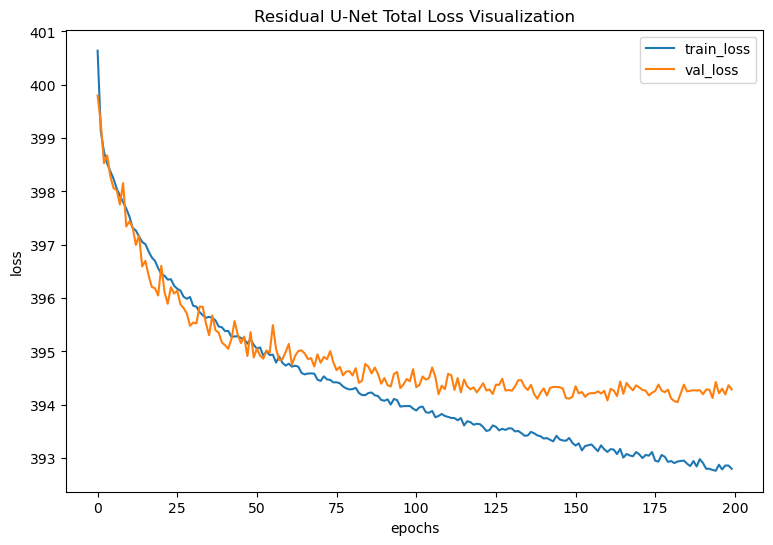

In [34]:
plt.figure(figsize = (9, 6))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'train_loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Residual U-Net Total Loss Visualization")
# plt.savefig("UNet_IIIT_Pet_dataset-Total_Loss.png")
plt.show()

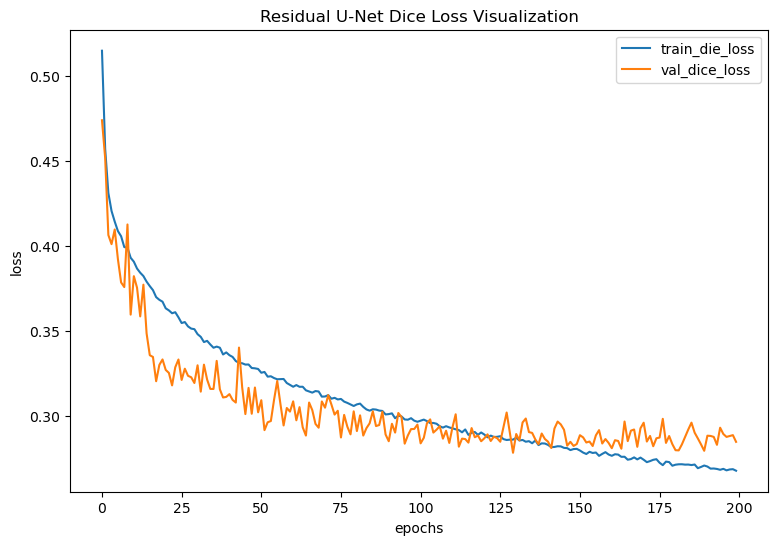

In [35]:
plt.figure(figsize = (9, 6))
plt.plot([train_history[e]['train_dice_loss'] for e in train_history.keys()], label = 'train_die_loss')
plt.plot([train_history[e]['val_dice_loss'] for e in train_history.keys()], label = 'val_dice_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Residual U-Net Dice Loss Visualization")
# plt.savefig("UNet_IIIT_Pet_dataset-Dice_Loss.png")
plt.show()

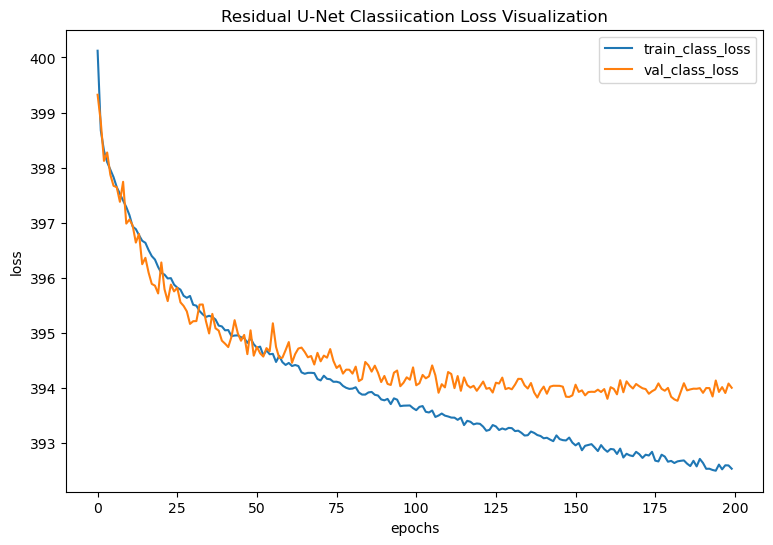

In [36]:
plt.figure(figsize = (9, 6))
plt.plot([train_history[e]['train_classification_loss'] for e in train_history.keys()], label = 'train_class_loss')
plt.plot([train_history[e]['val_classification_loss'] for e in train_history.keys()], label = 'val_class_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Residual U-Net Classiication Loss Visualization")
# plt.savefig("UNet_IIIT_Pet_dataset-Classification_Loss.png")
plt.show()

In [37]:
del model

In [39]:
# Initialize a U-Net model, load 'best' parameters-
trained_model = ResUNet(
    inp_channels = 3, op_channels = 3,
    features = [64, 128, 256, 512]
)

# Load 'best' trained parameters-
trained_model.load_state_dict(torch.load('Residual_UNet_IIIT_Pet_best_model.pth'))

<All keys matched successfully>

In [40]:
# Use data parallelism, specify GPUs to use-
trained_model = torch.nn.DataParallel(trained_model, device_ids = [0, 1, 2, 3, 4])

# Move to CUDA GPU-
trained_model.to(0)

DataParallel(
  (module): ResUNet(
    (contraction): ModuleList(
      (0): ResNet_Block(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResNet_Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps

In [41]:
print(f"U-Net model has {count_trainable_params(model = trained_model)} parameters")

U-Net model has 32436483 parameters


In [42]:
# Get a batch of validation/testing images and masks-
x, x_mask = next(iter(test_loader))

# Push to device-
x = x.to(0)
x_mask = x_mask.to(0)
# trained_parallel_net = parallel_net.to(0)

# Get forward propagation-
preds = trained_model(x)

In [43]:
preds.shape, x_mask.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 224, 224]))

In [44]:
# Do for image, output and mask-
x = torch.permute(input = x, dims = (0, 2, 3, 1))
x = x.cpu().detach().numpy()

preds = torch.permute(input = preds, dims = (0, 2, 3, 1))
preds = preds.cpu().detach().numpy()

x_mask = torch.permute(input = x_mask, dims = (0, 1, 2))
x_mask = x_mask.cpu().detach().numpy()

In [55]:
x.min(), x.max()

(-4.053115898461357e-09, 0.9999999964237213)

In [56]:
x_mask.min(), x_mask.max()

(1, 3)

In [45]:
# Sanity check-
x.shape, x_mask.shape, preds.shape

((64, 224, 224, 3), (64, 224, 224), (64, 224, 224, 3))

In [46]:
# Denormalize image-
x = imagenet_denorm(x)
x.shape

(64, 224, 224, 3)

In [47]:
# Use argmax to get pixel-wise K-way classification label-
preds = np.argmax(a = preds, axis = -1)

In [48]:
preds.shape

(64, 224, 224)

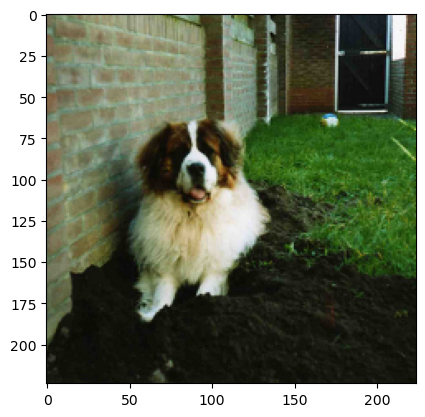

In [49]:
plt.imshow(x[10])
plt.show()

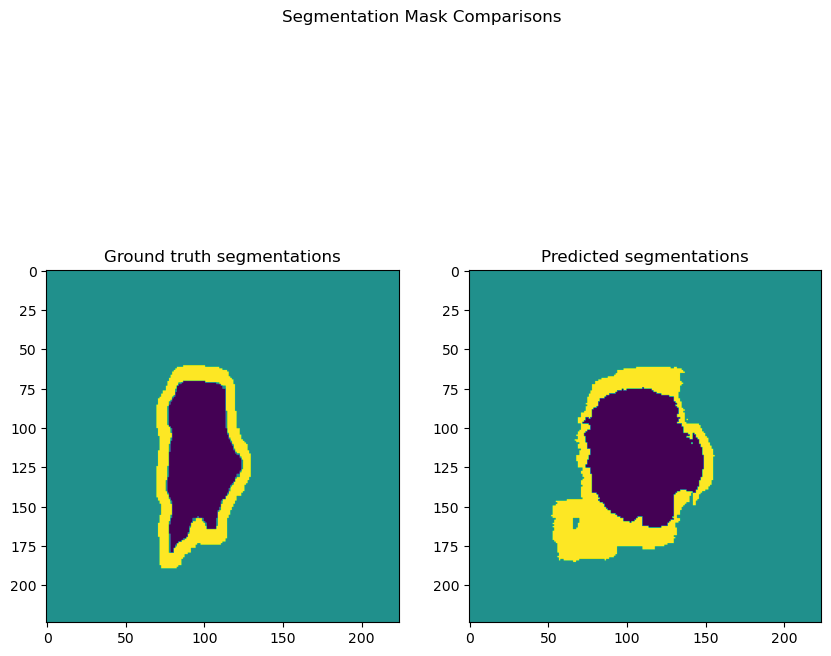

In [50]:
plt.figure(figsize = (10, 9))

plt.subplot(1, 2, 1)
plt.imshow(x_mask[10])
plt.title("Ground truth segmentations")

plt.subplot(1, 2, 2)
plt.imshow(preds[10])
plt.title("Predicted segmentations")

plt.suptitle("Segmentation Mask Comparisons")
plt.show()

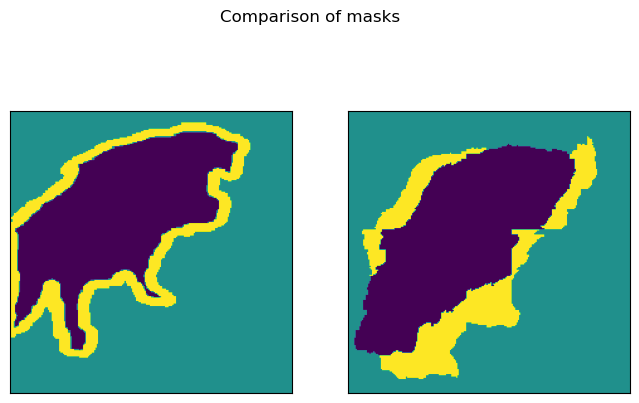

In [51]:
# Visualize image and its corresponding mask-
plt.figure(figsize = (8, 5))

plt.subplot(1, 2, 1)
plt.imshow(x_mask[5])
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(preds[5])
plt.xticks([])
plt.yticks([])

plt.suptitle("Comparison of masks")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

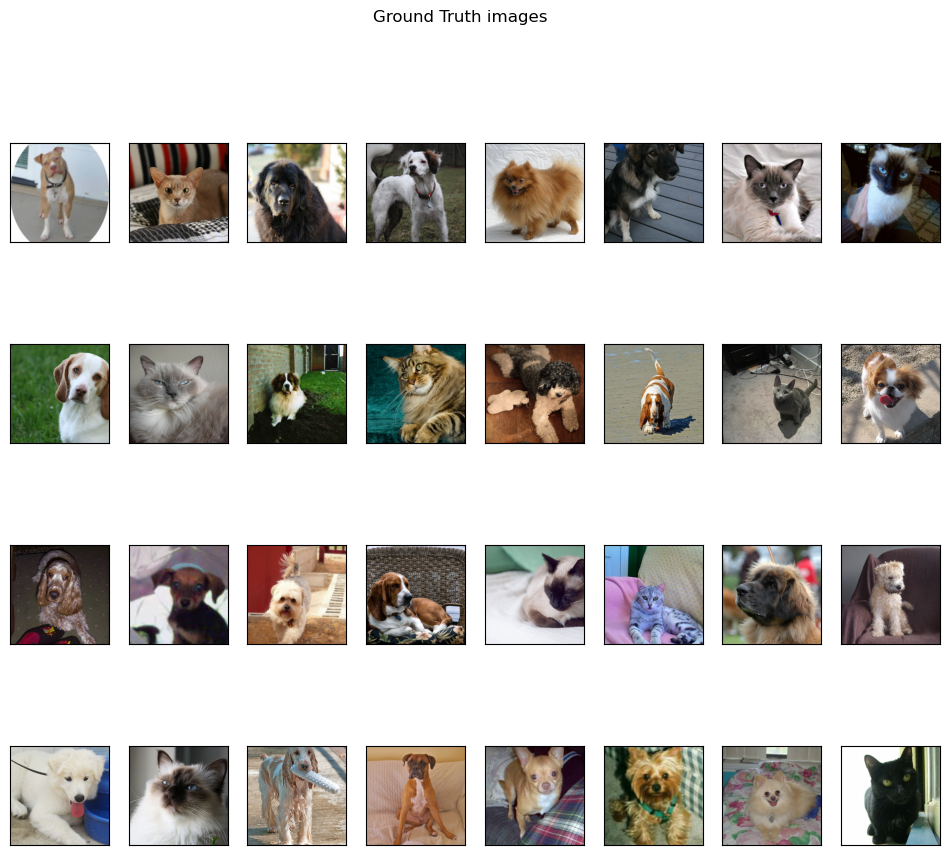

In [52]:
# Visualize images from training set-
plt.figure(figsize = (12, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(x[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Ground Truth images")
plt.show()

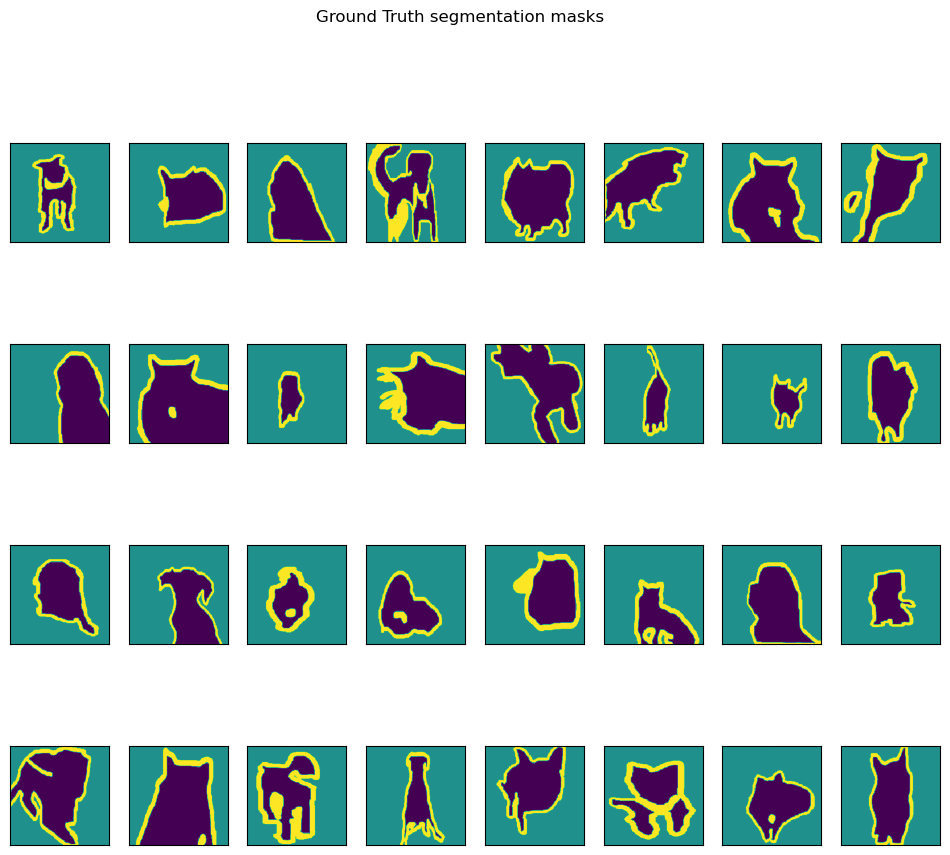

In [53]:
# Visualize images from training set-
plt.figure(figsize = (12, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(x_mask[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Ground Truth segmentation masks")
plt.show()

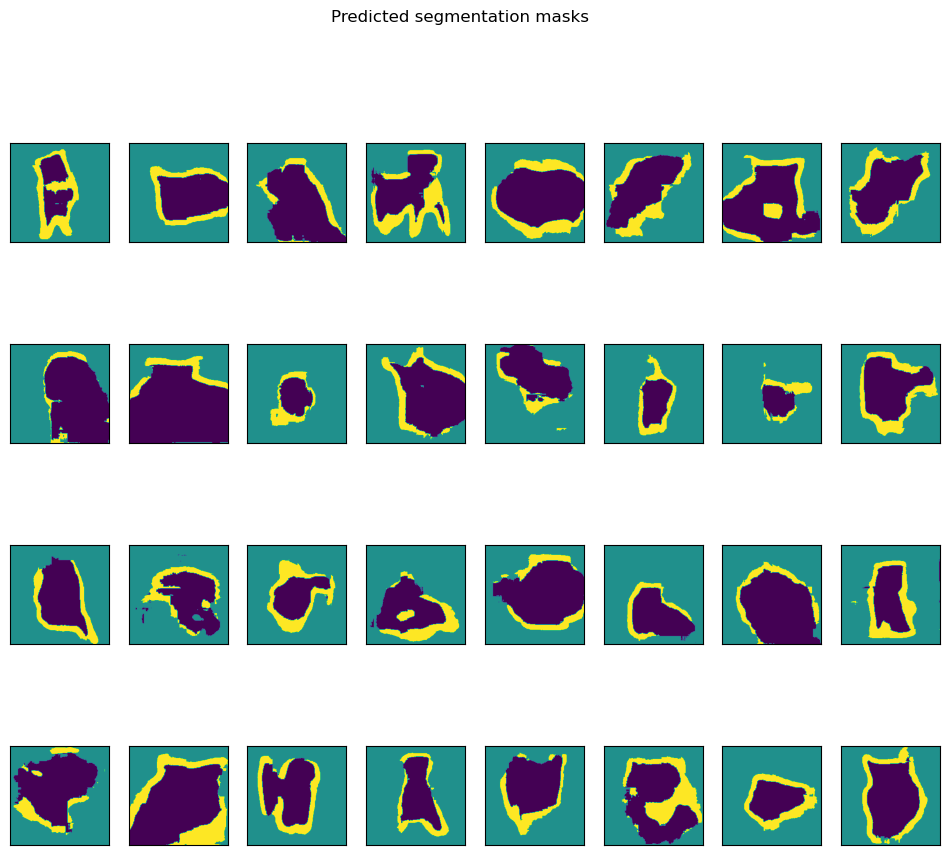

In [54]:
# Visualize images from training set-
plt.figure(figsize = (12, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(preds[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Predicted segmentation masks")
plt.show()

#### Observation

The network still doesn't seem to have learned the _best_ segmentation mask?!